## 중간고사: 컴퓨터 비전 문제 (201920934)
### 목표: 간단한 컨볼루션 신경망(CNN)을 사용하여 이미지 분류 작업을 수행 (Fashion-MNIST 데이터셋 사용, Pytorch로 구현)

### ❗️FashionMNIST 데이터셋 로드

In [ ]:

# !wget https://raw.githubusercontent.com/MicrosoftDocs/pytorchfundamentals/main/computer-vision-pytorch/pytorchcv.py # pytorchcv.py 파일 다운로드
%pip install torchvision # 토치비전 라이브러리 설치
%pip install torchinfo 
%pip install pytorchcv

import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from torchinfo import summary
import numpy as np
import pytorchcv

# fashion MNIST 데이터셋 로드
from pytorchcv import load_fashion_mnist, train, plot_results, plot_convolution, display_dataset, default_device

# FashionMNIST 데이터셋을 './data' 디렉토리에 다운로드 하고 데이터셋이 이미 존재하면 다운로드 스킵
# 데이터셋을 텐서로 변환 후 훈련용과 테스트용으로 나눔(텐서란 좌표 변화에 따라 특정 규칙에 따라 변환되는 숫자 배열)
# 각 데이터셋을 배치 크기(128)로 설정한 DataLoader에 로드함
# data_train, data_test, train_loader, test_loader에 접근할 수 있음
load_fashion_mnist(batch_size=128)

========================================================================================================================

## 1. 데이터 분석 (EDA)

#### # 클래스 갯수와 클래스 종류를 출력하고 훈련 데이터와 테스트 데이터의 갯수를 출력해본다.

In [2]:
# 데이터셋의 형태 살펴보기
print("클래스 갯수: ", len(data_train.classes));
print("클래스 종류: ", data_train.classes);

print("\n훈련 데이터 갯수: ",len(data_train));
print("테스트 데이터 갯수: ",len(data_test));

print("\ntrain_loader: ",train_loader);
print("test_loader: ",test_loader);

클래스 갯수:  10
클래스 종류:  ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

훈련 데이터 갯수:  60000
테스트 데이터 갯수:  10000

train_loader:  <torch.utils.data.dataloader.DataLoader object at 0x7fa70a798160>
test_loader:  <torch.utils.data.dataloader.DataLoader object at 0x7fa70a798400>


#### # 훈련 데이터셋에서 이미지를 선택하여 시각화

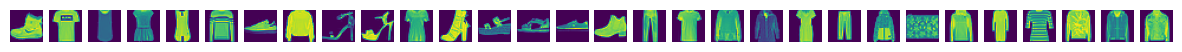

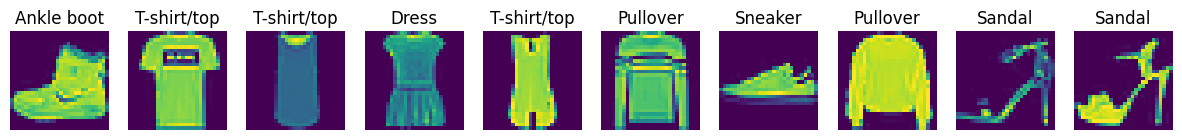

In [3]:
display_dataset(data_train, n=30)
display_dataset(data_train, n=10, classes=data_train.classes)
plt.show()


#### # 훈련 데이터셋 & 테스트 데이터셋 클래스별 데이터 갯수 출력 및 시각화

In [4]:
# 훈련 데이터셋의 클래스별 데이터 개수 출력
train_class_count = {}
for _, label in train_loader.dataset:
    if label not in train_class_count:
        train_class_count[label] = 1
    else:
        train_class_count[label] += 1

print("훈련 데이터 클래스별 갯수:")
for i in range(10):
    print(f"Class {i}: {train_class_count[i]}")

# 테스트 데이터셋의 클래스별 데이터 개수 출력
test_class_count = {}
for _, label in test_loader.dataset:
    if label not in test_class_count:
        test_class_count[label] = 1
    else:
        test_class_count[label] += 1

print("\n테스트 데이터 클래스별 갯수:")
for i in range(10):
    print(f"Class {i}: {test_class_count[i]}")

훈련 데이터 클래스별 갯수:
Class 0: 6000
Class 1: 6000
Class 2: 6000
Class 3: 6000
Class 4: 6000
Class 5: 6000
Class 6: 6000
Class 7: 6000
Class 8: 6000
Class 9: 6000

테스트 데이터 클래스별 갯수:
Class 0: 1000
Class 1: 1000
Class 2: 1000
Class 3: 1000
Class 4: 1000
Class 5: 1000
Class 6: 1000
Class 7: 1000
Class 8: 1000
Class 9: 1000


#### # 클래스별 데이터 갯수 시각화

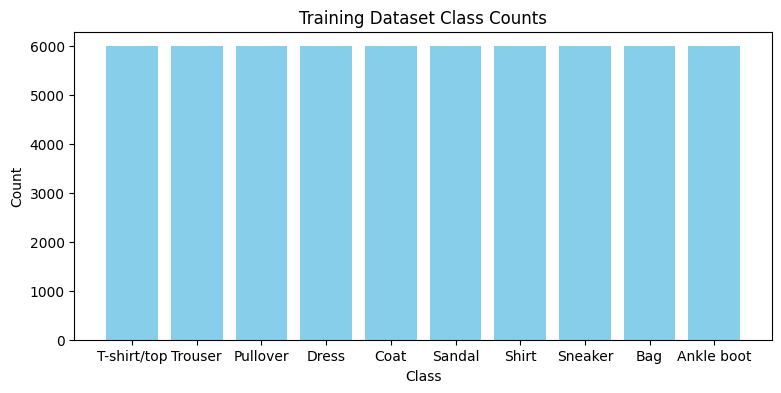

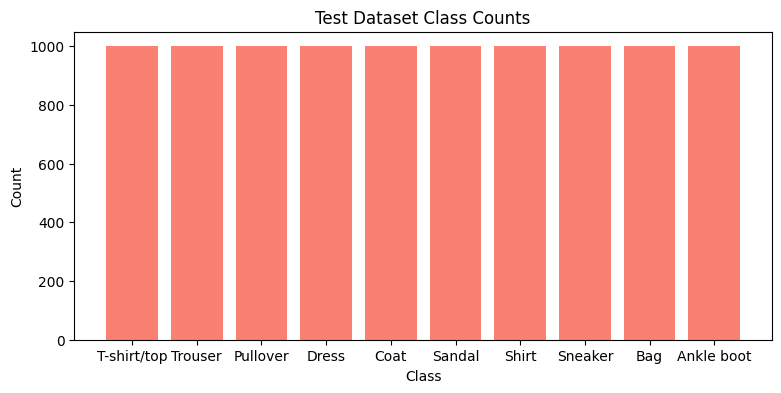

In [5]:
# 훈련 데이터셋의 클래스별 데이터 개수 시각화
plt.figure(figsize=(9, 4))
plt.bar(train_class_count.keys(), train_class_count.values(), color='skyblue')
plt.title('Training Dataset Class Counts')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(np.arange(10), data_train.classes, rotation=0)
plt.show()

# 테스트 데이터셋의 클래스별 데이터 개수 시각화
plt.figure(figsize=(9, 4))
plt.bar(test_class_count.keys(), test_class_count.values(), color='salmon')
plt.title('Test Dataset Class Counts')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(np.arange(10), data_train.classes, rotation=0)
plt.show()

========================================================================================================================

## 2. 모델 구축 및 훈련

#### # 세로, 가로 방향 엣지 감지

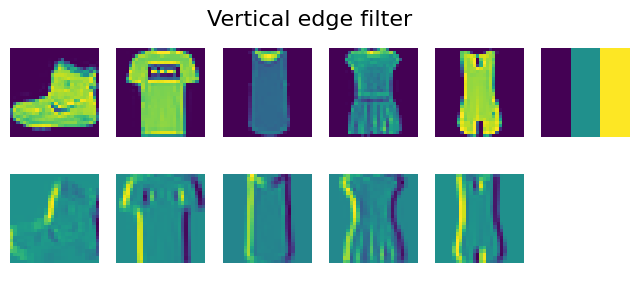

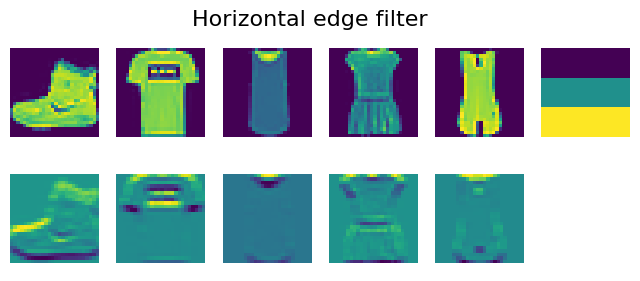

In [6]:
# 세로 방향 엣지 감지
plot_convolution(torch.tensor([[-1.,0.,1.],[-1.,0.,1.],[-1.,0.,1.]]),'Vertical edge filter')

# 가로 방향 엣지 감지
plot_convolution(torch.tensor([[-1.,-1.,-1.],[0.,0.,0.],[1.,1.,1.]]),'Horizontal edge filter')

세로 방향의 엣지를 감지하는 것이 물체의 경계를 더 잘 나타내는것을 확인할 수 있다.

#### # CNN 모델 구축
OneConv 클래스는 nn.Module 클래스를 상속받아 PyTorch의 신경망 모델을 구축하는 기본 클래스를 확장하고<br>
클래스 생성자 __init__ 메서드에서는 **컨볼루션 레이어(nn.Conv2d)**, **풀링 레이어(nn.MaxPool2d)**, **평탄화 레이어(nn.Flatten)**, 그리고 **완전 연결 레이어(nn.Linear)** 를 정의한다.

##### 1. 입력 데이터에 컨볼루션 레이어를 적용하고 활성화 함수로 ReLU를 사용하고<br>
##### 2. 이어서 풀링 레이어를 통해 공간 차원을 줄이고<br>
##### 3. 평탄화 레이어를 사용하여 다차원 데이터를 1차원 배열로 변환한다.<br>

마지막으로 완전 연결 레이어를 통해 출력을 생성하고, log_softmax 함수를 사용하여 확률 분포로 변환한다.

In [8]:
# 파이토치(PyTorch)를 사용하여 간단한 신경망 모델을 정의하고, 그 구조를 요약해서 출력하는 과정을 설명
import torch.nn as nn # 파이토치의 신경망 모듈(nn)을 임포트
%pip install torchsummary # 신경망 모델의 요약 정보를 제공하는 torchsummary 라이브러리를 설치
from torchsummary import summary

class OneConv(nn.Module): # nn.Module은 파이토치에서 모든 신경망 모듈의 기본 클래스
    def __init__(self): # 클래스의 생성자로, OneConv 객체가 생성될 때 초기화 과정을 정의
        super(OneConv, self).__init__() # 상위 클래스인 nn.Module의 생성자를 호출하여 클래스를 적절히 초기화
        self.conv = nn.Conv2d(in_channels=1,out_channels=9,kernel_size=(5,5)) # 입력 채널이 1개, 출력 채널이 9개인 2D 컨볼루션 레이어를 정의하고, 이를 객체의 conv 속성으로 할당
        self.pool = nn.MaxPool2d(kernel_size=(2, 2))  # Max 풀링 레이어 추가
        self.flatten = nn.Flatten() # 다차원 입력을 1차원 배열로 변환하는 Flatten 레이어를 정의하고, flatten 속성으로 할당
        self.fc_input_size = 9 * 12 * 12
        # 평탄화 레이어 이후의 출력 크기를 계산하여 이를 완전 연결 레이어의 입력 크기로 지정
        # self.fc.input_size개의 특성을 10개의 출력 특성으로 변환하는 완전 연결 레이어(또는 선형 레이어)를 정의하고, fc 속성으로 할당
        self.fc = nn.Linear(self.fc_input_size,10)

    def forward(self, x): # 모델의 순전파를 정의하는 메서드로 입력 텐서 x가 모델을 통과하는 과정을 설명
        if x.dim() == 5 and x.size(2) == 1:  # 입력 x의 차원이 예상치 못한 추가 차원을 포함하는 경우, 해당 차원을 제거
            x = x.squeeze(2)
        x = nn.functional.relu(self.conv(x)) # 정의된 컨볼루션 레이어를 입력 x에 적용한 후 ReLU 활성화 함수를 적용
        x = self.pool(x)  # 풀링 레이어를 컨볼루션 레이어 다음에 추가
        x = self.flatten(x) # ReLU의 출력을 flatten 레이어를 통해 평탄화
        x = nn.functional.log_softmax(self.fc(x),dim=1) # 평탄화된 벡터를 fc 레이어에 적용하고, 결과를 로그 소프트맥스 함수를 통해 처리하는데 이 함수는 다중 클래스 분류 문제에 대한 확률을 계산할 때 사용

        return x 

# OneConv 클래스의 인스턴스를 생성
net = OneConv()

# 생성된 모델 net의 요약 정보를 출력하는데 여기서 input_size는 모델이 기대하는 입력 데이터의 크기를 (채널 수, 높이, 너비) 형식으로 지정
summary(net,input_size=(1,1,28,28)) 

Note: you may need to restart the kernel to use updated packages.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 9, 24, 24]             234
         MaxPool2d-2            [-1, 9, 12, 12]               0
           Flatten-3                 [-1, 1296]               0
            Linear-4                   [-1, 10]          12,970
Total params: 13,204
Trainable params: 13,204
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.05
Estimated Total Size (MB): 0.11
----------------------------------------------------------------


요약: 총 학습 가능한 파라미터 수는 13,204개로, 컨볼루션 레이어의 가중치와 편향, 그리고 완전 연결 레이어의 가중치와 편향을 합산한 값이다.

#### # CNN 모델을 학습 및 검증
위에서 정의한 CNN 모델을 인자로 전달받아서 학습과 검증을 수행한다.<br>
모델의 파라미터를 최적화하기 위해 Adam 최적화 알고리즘을 선택하고, 손실 함수로는 CrossEntropyLoss 함수를 사용한다.

In [15]:
# PyTorch를 사용하여 신경망 모델을 학습하고 검증하는 과정을 구현

import torch # torch, torch.optim, torch.nn.functional 모듈을 임포트하는데 PyTorch에서 모델을 구성하고 최적화하는 데 필요한 함수와 클래스를 제공
from torch import optim
import torch.nn.functional as F

def train(model, train_loader, test_loader, epochs=5): # 함수를 정의하여 모델, 학습 데이터 로더, 테스트 데이터 로더, 그리고 에폭 수를 매개변수로 받음
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # 사용 가능한 경우 CUDA를 사용하고, 그렇지 않으면 CPU를 사용하도록 설정
    model.to(device) # 모델을 해당 장치로 이동
    optimizer = optim.Adam(model.parameters(), lr=0.001) # Adam 최적화 도구를 사용하여 모델의 매개변수를 최적화하고, 학습률은 0.001로 설정
    criterion = torch.nn.CrossEntropyLoss() # 다중 클래스 분류를 위한 크로스 엔트로피 손실 함수를 사용
    
    history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': [], 'val_acc': [], 'val_loss': []}
    
    # 에폭 수만큼 반복하면서 모델의 학습 및 평가를 수행하는데 학습 시에는 model.train()을 호출하여 모델을 학습 모드로 설정하고, 평가 시에는 model.eval()을 호출하여 평가 모드로 설정

    try:
        for epoch in range(epochs):
            model.train()
            train_loss, train_correct, train_total = 0, 0, 0
            for data, target in train_loader: # # 각 배치 데이터에 대해 데이터와 타겟을 장치로 이동시킨 후, 최적화 도구를 이용해 그래디언트를 초기화하고, 모델을 통해 예측을 수행
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = model(data)
                
                if output is None:
                    print("Warning: Model output is None.")
                    continue
                
                loss = criterion(output, target) # 손실을 계산하고, 역전파를 통해 그래디언트를 계산한 다음, 최적화 도구로 매개변수를 업데이트
                if loss is None:
                    print("Warning: Loss computation returned None.")
                    continue
                
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item() # 정확도와 손실을 기록하여 진행 상황을 모니터링
                _, predicted = torch.max(output.data, 1)
                train_total += target.size(0)
                train_correct += (predicted == target).sum().item()
            
            train_loss /= len(train_loader.dataset)
            train_acc = 100. * train_correct / train_total
            history['train_loss'].append(train_loss)
            history['train_acc'].append(train_acc)
            
            model.eval()
            test_loss, test_correct, test_total = 0, 0, 0
            with torch.no_grad():
                for data, target in test_loader:
                    data, target = data.to(device), target.to(device)
                    output = model(data)
                    if output is None:
                        print("Warning: Model output is None during evaluation.")
                        continue
                    
                    loss = criterion(output, target)
                    if loss is None:
                        print("Warning: Loss computation returned None during evaluation.")
                        continue
                    
                    test_loss += loss.item()
                    _, predicted = torch.max(output.data, 1)
                    test_total += target.size(0)
                    test_correct += (predicted == target).sum().item()
            
            test_loss /= len(test_loader.dataset)
            test_acc = 100. * test_correct / test_total
            history['test_loss'].append(test_loss)
            history['test_acc'].append(test_acc)
            
            print(f'Epoch {epoch+1}/{epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')
        
    except Exception as e: # 에러가 발생할 경우 처리하는데 에러 발생 시 해당 에러 메시지를 출력하고 None을 반환
        print(f"An error occurred: {e}")
        return None
    
    return history # 학습과 테스트 과정에서의 손실과 정확도를 기록한 history 딕셔너리를 반환



#### # 신경망 모델 훈련 & 훈련 과정에서의 손실과 정확도 모니터링 시각화

Epoch 1/5: Train Loss: 0.0022, Train Acc: 89.92%, Test Loss: 0.0027, Test Acc: 87.76%
Epoch 2/5: Train Loss: 0.0022, Train Acc: 90.14%, Test Loss: 0.0027, Test Acc: 87.98%
Epoch 3/5: Train Loss: 0.0021, Train Acc: 90.39%, Test Loss: 0.0027, Test Acc: 88.01%
Epoch 4/5: Train Loss: 0.0021, Train Acc: 90.52%, Test Loss: 0.0026, Test Acc: 88.17%
Epoch 5/5: Train Loss: 0.0021, Train Acc: 90.69%, Test Loss: 0.0026, Test Acc: 88.28%


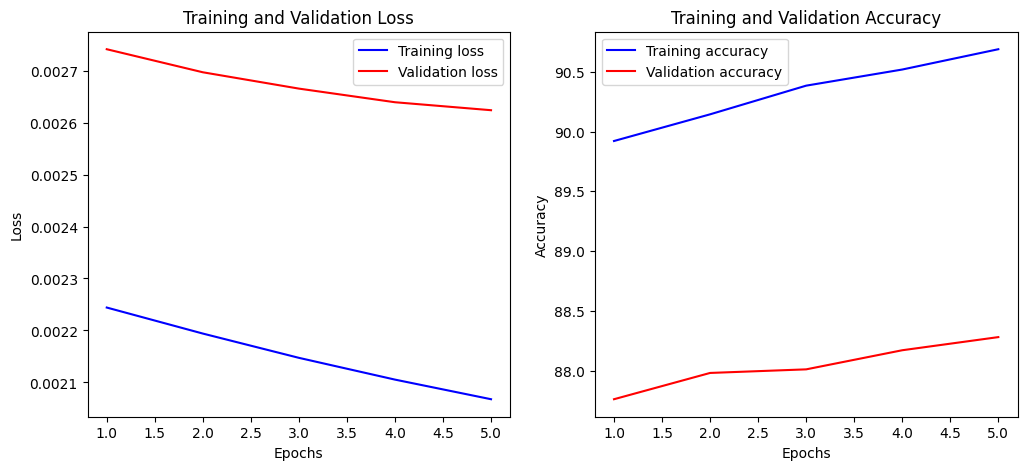

In [16]:
import matplotlib.pyplot as plt

def plot_results(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 5))

    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'b', label='Training loss')
    plt.plot(epochs, history['test_loss'], 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], 'b', label='Training accuracy')
    plt.plot(epochs, history['test_acc'], 'r', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# 신경망 모델 net을 학습시키고 그 결과를 처리하는 과정을 보여줌
# train 함수를 호출하여 신경망 모델 net을 학습시키는데 학습 데이터 로더 train_loader, 테스트 데이터 로더 test_loader를 사용하고, 총 5 에폭(epoch) 동안 학습을 수행하고 학습 과정에서 계산된 손실과 정확도 같은 통계 정보를 hist 변수에 저장
hist = train(net, train_loader, test_loader, epochs=5)

if hist is None:
    print("Training did not return any history.")
else:
    plot_results(hist)


에폭이 증가함에 따라 모델이 훈련되는동안 손실이 감소하고 정확도가 향상되는 것을 볼 수 있다.
이를 통해 모델이 데이터를 더 잘 이해하고 예측하는 것을 볼 수 있다.

========================================================================================================================

## 3. 모델 평가 및 결과 분석

#### # 테스트 데이터셋을 사용하여 모델을 평가하고 최종 정확도를 출력한다.
##### 1. 모델의 최종 정확도를 계산하고, 잘못 분류된 이미지를 식별하는 함수를 정의한다.
##### 2. 잘못 분류된 이미지를 식별하여 해당 이미지, 실제 레이블, 예측된 레이블을 따로 저장한다.
##### 3. 최종 정확도와 잘못 분류된 이미지, 레이블, 예측을 반환합니다.

In [22]:
def evaluate_model(model, test_loader):
    device = next(model.parameters()).device
    model.eval()  # 모델을 평가 모드로 설정
    correct = 0
    total = 0
    misclassified_images = []
    misclassified_labels = []
    misclassified_predictions = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # 잘못 분류된 이미지 식별
            misclassified_mask = predicted != labels
            misclassified_images.extend(images[misclassified_mask].cpu().numpy())
            misclassified_labels.extend(labels[misclassified_mask].cpu().numpy())
            misclassified_predictions.extend(predicted[misclassified_mask].cpu().numpy())

    accuracy = 100 * correct / total
    return accuracy, misclassified_images, misclassified_labels, misclassified_predictions

# 모델 평가 및 잘못 분류된 이미지 식별
accuracy, misclassified_images, misclassified_labels, misclassified_predictions = evaluate_model(net, test_loader)
print(f"Final Accuracy: {accuracy:.2f}%")


Final Accuracy: 88.95%


테스트 데이터셋을 사용하여 모델을 평가했을 때 최종 정확도는 88.95%가 나오는것을 확인할 수 있다.

#### # 잘못 분류된 이미지 분석 & 어떤 클래스가 모델에 의해 가장 잘못 분류되었는지를 식별

In [27]:
def analyze_misclassified_images(misclassified_images, misclassified_labels, misclassified_predictions, classes):
    misclassified_class_counts = {class_name: 0 for class_name in classes}  # 각 클래스별로 잘못 분류된 이미지의 수를 저장할 딕셔너리 초기화

    # 각 이미지에 대해 실제 레이블과 예측된 레이블을 비교하여 잘못 분류된 클래스별 카운트를 증가
    for true_label, predicted_label in zip(misclassified_labels, misclassified_predictions):
        true_class = classes[true_label]  # 실제 클래스
        predicted_class = classes[predicted_label]  # 예측된 클래스

        if true_class != predicted_class:
            misclassified_class_counts[true_class] += 1  # 실제 클래스와 예측된 클래스가 다른 경우 해당 클래스의 카운트 증가

    # 잘못 분류된 클래스별 비율 계산
    total_misclassified = sum(misclassified_class_counts.values())
    misclassified_class_ratios = {class_name: count / total_misclassified for class_name, count in misclassified_class_counts.items()}

    # 가장 많이 잘못 분류된 클래스 식별
    most_misclassified_class = max(misclassified_class_ratios, key=misclassified_class_ratios.get)
    most_misclassified_ratio = misclassified_class_ratios[most_misclassified_class]

    return misclassified_class_counts, misclassified_class_ratios, most_misclassified_class, most_misclassified_ratio

# 잘못 분류된 이미지들을 분석하고 가장 많이 잘못 분류된 클래스를 식별
misclassified_class_counts, misclassified_class_ratios, most_misclassified_class, most_misclassified_ratio = analyze_misclassified_images(misclassified_images, misclassified_labels, misclassified_predictions, data_train.classes)

print("클래스별 잘못 분류된 이미지 갯수:\n", misclassified_class_counts)
print("\n클래스별 잘못 분류된 이미지의 비율:\n", misclassified_class_ratios)
print("\n가장 많이 잘못 분류된 클래스:\n", most_misclassified_class)
print("\n가장 많이 잘못 분류된 클래스의 비율:\n", most_misclassified_ratio)


클래스별 잘못 분류된 이미지 갯수:
 {'T-shirt/top': 88, 'Trouser': 38, 'Pullover': 135, 'Dress': 78, 'Coat': 202, 'Sandal': 33, 'Shirt': 423, 'Sneaker': 62, 'Bag': 19, 'Ankle boot': 27}

클래스별 잘못 분류된 이미지의 비율:
 {'T-shirt/top': 0.07963800904977375, 'Trouser': 0.034389140271493215, 'Pullover': 0.12217194570135746, 'Dress': 0.07058823529411765, 'Coat': 0.18280542986425338, 'Sandal': 0.02986425339366516, 'Shirt': 0.38280542986425337, 'Sneaker': 0.056108597285067875, 'Bag': 0.017194570135746608, 'Ankle boot': 0.024434389140271493}

가장 많이 잘못 분류된 클래스:
 Shirt

가장 많이 잘못 분류된 클래스의 비율:
 0.38280542986425337


출력 결과를 통해 모델이 특히 'Shirt' 클래스를 잘못 이해하고 있는 것을 확인할 수 있다.